In [2]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.append(str(project_root))


## Library Imports

In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd

from pathlib import Path

import matplotlib.pyplot as plt
import plotly.express as px

from shapely.geometry import Polygon, MultiPolygon

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


## Data Loading

The data provided by the competition is stored as GeoJSON files.  
Each row corresponds to a geographical area (polygon) observed at multiple dates.

We load separately:

- The training set (`train.geojson`), which contains the target variable  
- The test set (`test.geojson`), used for the Kaggle submission  


In [4]:
def load_data():
    
    project_root = Path.cwd().parent  
    data_path = project_root / "data" / "raw"

    train_path = data_path / "train.geojson"
    test_path = data_path / "test.geojson"

    train_df = gpd.read_file(train_path)
    test_df = gpd.read_file(test_path)

    return train_df, test_df



train_df, test_df = load_data()

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)


Train shape: (296146, 45)
Test shape : (120526, 44)


## Data Structure

Before applying any transformations, it is important to understand the structure of the dataset:

- What variables are available  
- Which variable is the target  
- Which columns correspond to geometry or temporal information  

This section helps clarify what will be used later for feature engineering.

In [ ]:
train_df.columns


Index(['urban_type', 'geography_type', 'change_type', 'img_red_mean_date1',
       'img_green_mean_date1', 'img_blue_mean_date1', 'img_red_std_date1',
       'img_green_std_date1', 'img_blue_std_date1', 'img_red_mean_date2',
       'img_green_mean_date2', 'img_blue_mean_date2', 'img_red_std_date2',
       'img_green_std_date2', 'img_blue_std_date2', 'img_red_mean_date3',
       'img_green_mean_date3', 'img_blue_mean_date3', 'img_red_std_date3',
       'img_green_std_date3', 'img_blue_std_date3', 'img_red_mean_date4',
       'img_green_mean_date4', 'img_blue_mean_date4', 'img_red_std_date4',
       'img_green_std_date4', 'img_blue_std_date4', 'img_red_mean_date5',
       'img_green_mean_date5', 'img_blue_mean_date5', 'img_red_std_date5',
       'img_green_std_date5', 'img_blue_std_date5', 'date0',
       'change_status_date0', 'date1', 'change_status_date1', 'date2',
       'change_status_date2', 'date3', 'change_status_date3', 'date4',
       'change_status_date4', 'index', 'geometry']

### Variables Overview

The dataset contains several groups of variables:

- **Target variable**
  - `change_type`: type of change to predict (6 classes)

- **Contextual categorical variables**
  - `urban_type`
  - `geography_type`

- **Temporal variables**
  - `date1` to `date5`
  - `change_status_date0` to `change_status_date4`

- **Satellite image-derived variables**
  - RGB means and standard deviations computed at each date

- **Geometry**
  - `geometry`: polygon representing the area under study


## Class Distribution

Before training a model, it is important to analyze the distribution of the target variable.  
A strong imbalance between classes can significantly impact performance, especially when the evaluation metric is the macro F1-score.

In [6]:
# Comptage des occurrences par classe
class_counts = (
    train_df["change_type"]
    .value_counts()
    .sort_index()
    .reset_index()
)

class_counts.columns = ["change_type", "count"]

# Calcul des pourcentages
total = class_counts["count"].sum()
class_counts["percentage"] = 100 * class_counts["count"] / total

# Visualisation
fig = px.bar(
    class_counts,
    x="change_type",
    y="count",
    text=class_counts["percentage"].round(2).astype(str) + " %",
    title="Répartition des classes de changement",
    color="change_type"
)

fig.update_traces(textposition="outside")

fig.update_layout(
    xaxis_title="Type de changement",
    yaxis_title="Nombre d'observations",
    showlegend=False,
    height=600
)

fig.show()


### Class Distribution Analysis and Metric Selection

The class distribution is highly imbalanced.  
The *Residential* and *Commercial* categories represent a large majority of the observations, while some classes such as *Industrial* or *Mega Projects* are underrepresented.

In this context, a standard metric like accuracy would be misleading, as a model could achieve a high score by correctly predicting only the majority classes.

The selected evaluation metric is therefore the **macro F1-score**, computed as follows:
- The F1-score is calculated **independently for each class**;
- Then the **arithmetic mean** of these scores is computed, **without weighting** by class frequency. As a result, minority classes have a significant impact on the final metric.

Each class thus contributes equally to the final score, which allows us:
- To penalize poor performance on rare classes;
- To obtain a more representative evaluation of the model’s overall behavior;
- And to align directly with the evaluation metric used on the Kaggle platform.

The final model will be optimized using this metric.

## Temporal Analysis of Observations

The data comes from multiple successive observation campaigns.  
To better understand the temporal structure of the dataset, we analyze the distribution of observations over time using the first available date (`date0`).

This analysis helps identify potential temporal variations and verify the overall consistency of the data across the studied period.

In [ ]:
df_time = train_df[["date0", "change_type"]].copy()
df_time["date0"] = pd.to_datetime(df_time["date0"], errors="coerce")
df_time = df_time.dropna(subset=["date0"])

df_time["year"] = df_time["date0"].dt.year

yearly_counts = (
    df_time.groupby(["year", "change_type"])
           .size()
           .reset_index(name="count")
)


In [8]:
fig = px.line(
    yearly_counts,
    x="year",
    y="count",
    color="change_type",
    markers=True,
    title="Évolution annuelle du nombre d'observations par type de changement"
)

fig.update_layout(
    xaxis_title="Année",
    yaxis_title="Nombre d'observations",
    height=520
)

fig.show()


In [ ]:
fig = px.histogram(
    df_time,
    x="year",
    facet_col="change_type",
    facet_col_wrap=3,
    title="Répartition temporelle des observations par type de changement",
    color_discrete_sequence=["#4C72B0"]
)

fig.update_layout(
    height=650,
    showlegend=False
)

fig.show()


In [10]:
df_tmp = train_df[["date0", "change_type"]].copy()
df_tmp["date0"] = pd.to_datetime(df_tmp["date0"], errors="coerce")
df_tmp = df_tmp.dropna(subset=["date0", "change_type"])

df_tmp["month"] = df_tmp["date0"].dt.to_period("M").dt.to_timestamp()

monthly_counts = (
    df_tmp.groupby(["month", "change_type"])
          .size()
          .reset_index(name="count")
)

monthly_counts["total"] = monthly_counts.groupby("month")["count"].transform("sum")
monthly_counts["proportion"] = monthly_counts["count"] / monthly_counts["total"]

fig = px.area(
    monthly_counts,
    x="month",
    y="proportion",
    color="change_type",
    title="Contribution relative des classes au fil du temps",
)

fig.update_layout(
    xaxis_title="Temps (mois)",
    yaxis_title="Proportion",
    height=520,
    legend_title="Type de changement"
)

fig.show()


### Summary of the Temporal Analysis

The temporal analysis reveals a non-uniform evolution in the number of observations across years.  
The *Residential* and *Commercial* classes account for the majority of observations throughout the period, with noticeable year-to-year variations, while the *Industrial* and *Mega Projects* classes remain marginal and sparsely represented.

The class-wise temporal distribution confirms that some categories exhibit a more stable dynamic, whereas others are characterized by more sporadic occurrences.  
Despite these fluctuations, the relative contribution of each class remains broadly consistent over time, with no major structural breaks.

These findings suggest that temporal information provides a meaningful signal, but it should be leveraged in an aggregated manner and combined with other sources of information (geometric, contextual, and visual) in the subsequent modeling pipeline.

## Evolution of Change Status

For each area, the dataset contains a sequence of status variables describing the progression of the observed change at different dates (`change_status_date0` to `change_status_date4`).

This section aims to analyze how these statuses evolve over time and to identify the general dynamics associated with the different types of change.
``

In [11]:
# Liste des colonnes de statut
status_cols = [f"change_status_date{i}" for i in range(5)]

# Passage au format long
df_status = train_df[["change_type"] + status_cols].copy()

df_status_long = df_status.melt(
    id_vars="change_type",
    value_vars=status_cols,
    var_name="timepoint",
    value_name="status"
)

# Extraction de l'indice temporel (0 à 4)
df_status_long["timepoint"] = (
    df_status_long["timepoint"]
    .str.extract(r"(\d)")
    .astype(int)
)


In [12]:
status_counts = (
    df_status_long
    .groupby(["timepoint", "status"])
    .size()
    .reset_index(name="count")
)

fig = px.bar(
    status_counts,
    x="timepoint",
    y="count",
    color="status",
    title="Répartition des statuts de changement au fil des observations",
)

fig.update_layout(
    xaxis_title="Indice temporel",
    yaxis_title="Nombre d'observations",
    height=520,
    legend_title="Statut"
)

fig.show()


In [13]:
status_counts_class = (
    df_status_long
    .groupby(["change_type", "timepoint", "status"])
    .size()
    .reset_index(name="count")
)

fig = px.line(
    status_counts_class,
    x="timepoint",
    y="count",
    color="status",
    facet_col="change_type",
    facet_col_wrap=3,
    markers=True,
    title="Évolution des statuts par type de changement"
)

fig.update_layout(
    height=650,
    legend_title="Statut"
)

fig.show()


### Interpretation of Change Status

The overall distribution of change statuses shows a relatively stable structure across observations.  
Certain statuses, such as *Construction Done*, *Land Cleared*, or *Prior Construction*, remain largely dominant at each time index, suggesting a coherent progression of the observed projects.

The class-wise analysis reveals differentiated dynamics depending on the type of change.  
The *Residential* and *Commercial* categories exhibit more pronounced status evolution, while the *Industrial* and *Mega Projects* classes remain more marginal, with lower volumes and limited variation.

These findings indicate that the sequence of statuses carries meaningful structural information about both the nature and progression of changes.  
In the next steps, this information will be incorporated as derived variables to enrich the feature engineering process and improve the model’s discriminative capacity.

## Column Name Harmonization

The dataset combines multiple families of date-indexed variables:

- RGB image statistics (`..._date1` to `..._date5`)  
- Observation dates (`date0` to `date4`)  
- Change statuses (`change_status_date0` to `change_status_date4`)  

To avoid confusion during sequential processing, the temporal indices are aligned as follows:  
`date0..date4` → `date1..date5`  
`change_status_date0..date4` → `change_status_date1..date5`

The same transformation is applied to both the training and test sets to ensure full consistency.

In [14]:
from src.feature_eng import fix_date_column_names

train_df = fix_date_column_names(train_df)
test_df = fix_date_column_names(test_df)

# Vérification rapide
[c for c in train_df.columns if c.startswith("date") or c.startswith("change_status_date")]


['date1',
 'change_status_date1',
 'date2',
 'change_status_date2',
 'date3',
 'change_status_date3',
 'date4',
 'change_status_date4',
 'date5',
 'change_status_date5']

## Missing Values Analysis

Before defining a preprocessing strategy, we conduct a detailed analysis of missing values.

Objectives:

1. Quantify missing values (both train and test) to identify the most affected columns.  
2. Focus on temporal columns (`date1..date5`, `change_status_date1..date5`) since they structure the observation sequence.  
3. Check whether missing dates are associated with the target variable (`change_type`) using a statistical test.  
4. Prepare a robust strategy: instead of removing observations by default, we retain the information through explicit indicators (`has_missing_date`, `nb_missing_dates`) and compare multiple approaches during the modeling phase.


In [15]:
def missing_summary(df: pd.DataFrame, name: str, top_k: int = 15) -> pd.DataFrame:
    out = (
        pd.DataFrame({
            "nb_missing": df.isna().sum(),
            "pct_missing": (df.isna().mean() * 100),
        })
        .query("nb_missing > 0")
        .sort_values("pct_missing", ascending=False)
    )
    print(f"[{name}] Colonnes avec valeurs manquantes : {out.shape[0]} / {df.shape[1]}")
    display(out.head(top_k))
    return out

missing_train = missing_summary(train_df, "TRAIN", top_k=20)
missing_test  = missing_summary(test_df,  "TEST",  top_k=20)



[TRAIN] Colonnes avec valeurs manquantes : 40 / 45


,nb_missing,pct_missing
img_red_mean_date1,1954,0.65981
img_green_std_date3,1954,0.65981
img_blue_std_date5,1954,0.65981
img_green_std_date5,1954,0.65981
img_red_std_date5,1954,0.65981
img_blue_mean_date5,1954,0.65981
img_green_mean_date5,1954,0.65981
img_red_mean_date5,1954,0.65981
img_blue_std_date4,1954,0.65981
img_green_std_date4,1954,0.65981


[TEST] Colonnes avec valeurs manquantes : 40 / 44


,nb_missing,pct_missing
change_status_date5,729,0.604849
date3,729,0.604849
change_status_date1,729,0.604849
date2,729,0.604849
change_status_date2,729,0.604849
date1,729,0.604849
change_status_date3,729,0.604849
date4,729,0.604849
change_status_date4,729,0.604849
date5,729,0.604849


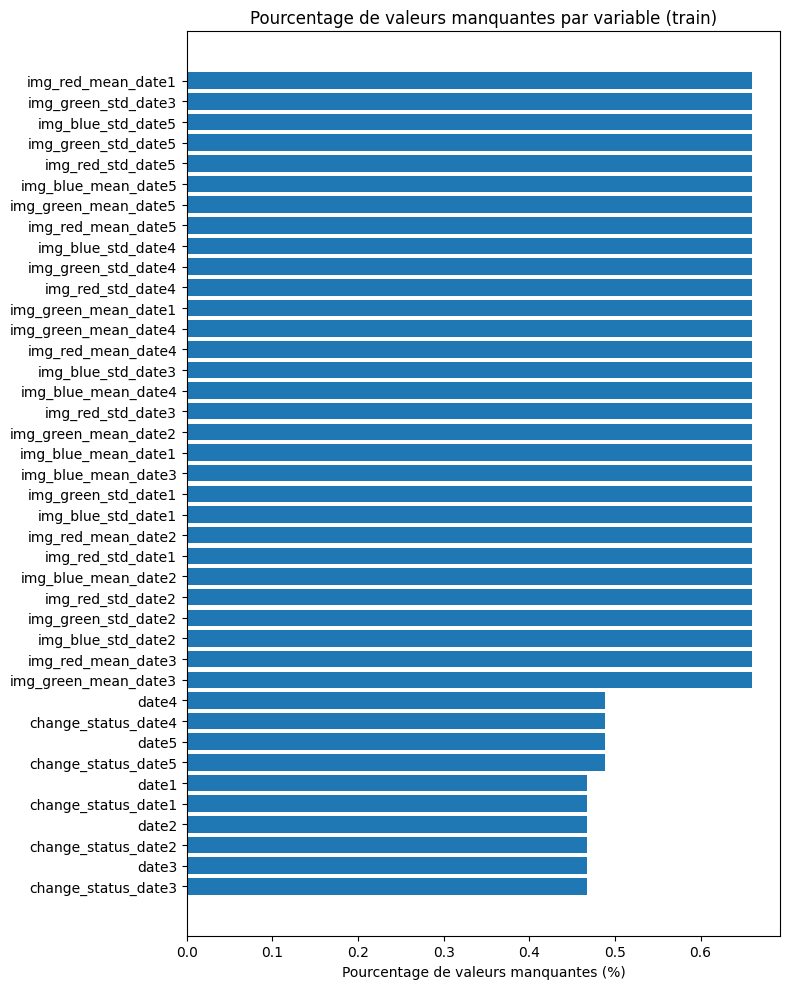

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 10))

plt.barh(
    missing_train.index,
    missing_train["pct_missing"],
)

plt.xlabel("Pourcentage de valeurs manquantes (%)")
plt.title("Pourcentage de valeurs manquantes par variable (train)")
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


### Focus on Temporal Variables

Temporal information structures the observation sequence:

- `date1..date5`: acquisition dates  
- `change_status_date1..change_status_date5`: status at each date  

We first quantify missing values **only** on these columns, then create row-level indicators:

- `has_missing_date`: at least one missing date  
- `nb_missing_dates`: number of missing dates in the row  

In [17]:
date_cols = [f"date{i}" for i in range(1, 6)]
status_cols = [f"change_status_date{i}" for i in range(1, 6)]
temporal_cols = date_cols + status_cols

missing_temporal_train = (
    pd.DataFrame({
        "nb_missing": train_df[temporal_cols].isna().sum(),
        "pct_missing": (train_df[temporal_cols].isna().mean() * 100).round(4),
    })
    .sort_values("pct_missing", ascending=False)
)

display(missing_temporal_train)

# Indicateurs ligne par ligne (sur les dates uniquement)
train_df["has_missing_date"] = train_df[date_cols].isna().any(axis=1)
train_df["nb_missing_dates"] = train_df[date_cols].isna().sum(axis=1)

train_missing_rate = train_df["has_missing_date"].value_counts(normalize=True) * 100
train_missing_rate



,nb_missing,pct_missing
date4,1448,0.4889
date5,1448,0.4889
change_status_date4,1448,0.4889
change_status_date5,1448,0.4889
date1,1383,0.4670
date2,1383,0.4670
date3,1383,0.4670
change_status_date1,1383,0.4670
change_status_date2,1383,0.4670
change_status_date3,1383,0.4670


has_missing_date
False    99.511052
True      0.488948
Name: proportion, dtype: float64

In [18]:
# --- Distribution des classes selon la présence de dates manquantes ---

distribution_missing = (
    train_df
    .groupby(["has_missing_date", "change_type"])
    .size()
    .reset_index(name="count")
)

# Normalisation par groupe (True / False)
distribution_missing["proportion"] = (
    distribution_missing
    .groupby("has_missing_date")["count"]
    .transform(lambda x: x / x.sum() * 100)
)

distribution_missing["proportion2"] = (
    distribution_missing
    .groupby("change_type")["count"]
    .transform(lambda x: x / x.sum() * 100)
)


distribution_missing


,has_missing_date,change_type,count,proportion,proportion2
0,False,Commercial,100006,33.935079,99.585748
1,False,Demolition,31396,10.653618,99.641372
2,False,Industrial,1311,0.444862,99.018127
3,False,Mega Projects,149,0.050560,98.675497
4,False,Residential,147607,50.087547,99.442180
5,False,Road,14229,4.828333,99.468717
6,True,Commercial,416,28.729282,0.414252
7,True,Demolition,113,7.803867,0.358628
8,True,Industrial,13,0.897790,0.981873
9,True,Mega Projects,2,0.138122,1.324503


### Independence Test Between Missing Values and Target Variable

We aim to determine whether the presence of missing dates is independent of the change type (`change_type`).

To do so, we use a **chi-square test of independence**.

#### Test Principle

The chi-square test compares:

- The observed distribution of classes according to the presence or absence of missing dates;  
- The expected distribution assuming the two variables are independent.

It is based on the statistic:

$$
\chi^2 = \sum \frac{(O - E)^2}{E}
$$

where:
- $O$ represents the observed frequencies,  
- $E$ represents the expected frequencies under the independence assumption.

#### Hypotheses

- H₀: The presence of missing dates is independent of the change type.  
- H₁: There is a dependency between the two variables.

If the p-value is below 0.05, we reject H₀ and conclude that missing values are associated with the target variable.

In [19]:
from scipy.stats import chi2_contingency

# Table de contingence
contingency_table = pd.crosstab(
    train_df["has_missing_date"],
    train_df["change_type"]
)

chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Chi² statistic :", round(chi2, 4))
print("p-value :", p_value)


Chi² statistic : 46.2899
p-value : 7.927661898082582e-09


### Interpretation of the Chi-Square Test

The obtained p-value is extremely small (≈ 7.9 × 10⁻⁹), well below the 5% threshold.

We therefore reject the null hypothesis of independence ($H_0$).

This means that the presence of missing dates is not completely random:  
it is statistically associated with the change type (`change_type`).

However, this result should be interpreted with caution:

- The dataset is very large (~296,000 observations).  
- With a large sample size, even small deviations can produce highly significant p-values.  
- The observed proportions remain globally close to the overall class distribution.

In practice, the effect appears statistically significant but likely of moderate magnitude.

### Missing Values Analysis in the Test Set

Before defining a preprocessing strategy, we verify that the structure of missing values in the test set is consistent with what was observed in the training set.

The objective is to detect potential differences that could affect the model’s ability to generalize.


In [20]:
# Focus sur les colonnes temporelles dans le test
missing_temporal_test = (
    pd.DataFrame({
        "nb_missing": test_df[temporal_cols].isna().sum(),
        "pct_missing": (test_df[temporal_cols].isna().mean() * 100).round(4),
    })
    .sort_values("pct_missing", ascending=False)
)

display(missing_temporal_test)

# Indicateur ligne par ligne dans le test
test_df["has_missing_date"] = test_df[date_cols].isna().any(axis=1)
test_df["nb_missing_dates"] = test_df[date_cols].isna().sum(axis=1)

test_missing_rate = test_df["has_missing_date"].value_counts(normalize=True) * 100
test_missing_rate


,nb_missing,pct_missing
date1,729,0.6048
date2,729,0.6048
date3,729,0.6048
date4,729,0.6048
date5,729,0.6048
change_status_date1,729,0.6048
change_status_date2,729,0.6048
change_status_date3,729,0.6048
change_status_date4,729,0.6048
change_status_date5,729,0.6048


has_missing_date
False    99.395151
True      0.604849
Name: proportion, dtype: float64

### Train / Test Comparison

The percentage of rows containing at least one missing date is:

- ≈ 0.49% in the training set  
- ≈ 0.60% in the test set  

These proportions are very close, and the structure of missing values is similar in both datasets (dates and associated statuses).

Therefore, we do not detect any major structural shift between train and test regarding missing values.

However, even though the structure is comparable, the treatment may differ between train and test to avoid any data leakage and to comply with the specific constraints of the test set.

The final strategy will be determined after empirically comparing several approaches during the modeling phase.


## Reordering Dates and Associated Variables

When exploring the dataset, we observe that the columns `date1`…`date5` are not always strictly ordered chronologically.  
However, several variables depend on this temporal order:

- the statuses `change_status_date1`…`change_status_date5`,  
- the image statistics `img_*_date1`…`img_*_date5`.  

To ensure a coherent interpretation (oldest date → `date1`, most recent → `date5`), we apply a **row-wise sorting procedure**:

1. Convert dates to `datetime` format  
2. Compute the sorted order for each observation  
3. Apply a synchronous permutation to dates, statuses, and image features  

This step is applied **identically to both the training and test sets**.

In [21]:
from src.feature_eng import reorder_temporal_blocks

# Application du réordonnancement temporel
train_df = reorder_temporal_blocks(train_df, n_dates=5)
test_df  = reorder_temporal_blocks(test_df,  n_dates=5)

# Vérification rapide
train_df[["date1","date2","date3","date4","date5"]].head(3)


,date1,date2,date3,date4,date5
0,09-12-2013,10-09-2016,24-07-2017,01-08-2018,22-07-2019
1,09-12-2013,10-09-2016,24-07-2017,01-08-2018,22-07-2019
2,09-12-2013,10-09-2016,24-07-2017,01-08-2018,22-07-2019


## Transformation of Multi-Valued Categorical Columns

The columns `geography_type` and `urban_type` contain multiple categories separated by commas.

Each observation may belong to several types (e.g., "River, Hills").

We transform these columns into a multi-hot representation:

- Token splitting  
- Value cleaning  
- Vocabulary learning on the training set  
- Consistent application to the test set  

This approach ensures a stable encoding between train and test.

In [22]:
from src.feature_eng import multihot_encode_column

train_df, test_df, geo_mlb = multihot_encode_column(
    train_df, test_df, "geography_type", "geo"
)
train_df, test_df, urb_mlb = multihot_encode_column(
    train_df, test_df, "urban_type", "urb"
)
    

print("shape:", train_df.shape)
print("shape:", test_df.shape)


shape: (296146, 61)
shape: (120526, 60)


In [ ]:
test_df.head(1)


,img_red_mean_date1,img_green_mean_date1,img_blue_mean_date1,img_red_std_date1,img_green_std_date1,img_blue_std_date1,img_red_mean_date2,img_green_mean_date2,img_blue_mean_date2,img_red_std_date2,...,geo__Hills,geo__Lakes,geo__River,geo__Snow,geo__Sparse Forest,urb__Dense Urban,urb__Industrial,urb__Rural,urb__Sparse Urban,urb__Urban Slum
0,187.051282,158.300672,140.517298,24.176292,22.166941,22.843903,194.900285,158.205433,136.564611,29.42589,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train_df.head(1)


,change_type,img_red_mean_date1,img_green_mean_date1,img_blue_mean_date1,img_red_std_date1,img_green_std_date1,img_blue_std_date1,img_red_mean_date2,img_green_mean_date2,img_blue_mean_date2,...,geo__Hills,geo__Lakes,geo__River,geo__Snow,geo__Sparse Forest,urb__Dense Urban,urb__Industrial,urb__Rural,urb__Sparse Urban,urb__Urban Slum
0,Road,125.773062,139.833243,134.900701,28.269984,28.264907,25.008032,150.766726,158.964529,149.356684,...,0,0,0,0,0,0,0,0,1,0


## Encodage de la variable cible

La variable `change_type` correspond à la classe à prédire (6 catégories).  
Pour entraîner un modèle de classification, on encode ces classes sous forme d’entiers en suivant **le mapping officiel de l’énoncé**.

Cette étape concerne **uniquement le jeu d’entraînement** : le jeu de test ne contient pas de labels.

In [25]:
label_map = {
    "Demolition": 0,
    "Road": 1,
    "Residential": 2,
    "Commercial": 3,
    "Industrial": 4,
    "Mega Projects": 5,
}

def encode_target(df, target="change_type"):
    df = df.copy()
    df[target] = df[target].map(label_map)

    # Sanity check
    if df[target].isna().any():
        unknown = df.loc[df[target].isna(), target].unique()
        raise ValueError(f"Labels non reconnus dans {target}: {unknown}")

    return df

# On encode uniquement les trains (pas le test)
train_df = encode_target(train_df)


# Check rapide (distribution par stratégie)
display(train_df["change_type"].value_counts().sort_index())


change_type
0     31509
1     14305
2    148435
3    100422
4      1324
5       151
Name: count, dtype: int64

## Selected Strategies for Handling Missing Values

After analyzing the structure of the data (truncated time sequences) and the constraints of the supervised models used (no native support for missing values), only strategies that guarantee **both train and test datasets without NaN values** are retained.

Each strategy corresponds to a coherent *(train, test)* pair and is evaluated empirically during the modeling phase (cross-validation + macro F1 score).

The differences between strategies are based on two main decisions:

1. Whether to remove training rows containing missing dates  
2. The imputation method for numerical and categorical variables  
   - Median for numerical variables  
   - Mode (majority class) for categorical status variables  
   - Parameters computed either on the train set only (proper ML practice) or separately on train and test  

Explicit indicators of missing dates (`has_missing_date`, `nb_missing_dates`) are added when relevant.

---

### Strategy 1 — Train-based Imputation (Standard Approach) — Selected

- Train:
  - No row removal  
  - Median of numerical variables computed on the train set  
  - Mode of categorical variables computed on the train set  
  - Addition of missing-date indicators  

- Test:
  - Application of the same statistics computed on the train set  
  - Addition of missing-date indicators  

This approach is methodologically correct (no data leakage).  
It is selected as the primary strategy and is expected to provide the most stable and generalizable performance.

---

### Strategy 2 — Train Filtering + Train-based Imputation

- Train:
  - Removal of rows containing at least one missing date  
  - Medians/modes computed on the filtered train set  

- Test:
  - Imputation using statistics from the filtered train set  
  - Addition of missing-date indicators  

Hypothesis: incomplete training observations introduce noise.  
This strategy combines noise reduction with statistical consistency.

---

### Strategy 3 — Independent Imputation (Train and Test Separately)

- Train:
  - Median/mode computed on the train set  
  - Addition of missing-date indicators  

- Test:
  - Median/mode computed independently on the test set  
  - Addition of missing-date indicators  

This approach is more flexible but less methodologically rigorous.  
It allows evaluation of test-specific adjustment effects.

---

### Strategy 4 — Train Filtering + Independent Imputation (Initial Notebook Approach)

- Train:
  - Removal of rows containing missing dates  

- Test:
  - Imputation computed only on the test set  
  - Addition of missing-date indicators  

This corresponds to the approach implemented in the initial notebook and is included for comparative reference.

---

### Experimental Objective

All four strategies produce fully usable datasets (no NaN values).  
The final choice is determined exclusively by cross-validation performance and Kaggle leaderboard results.

For this study, Strategy 1 (train-based imputation) is adopted as the main modeling approach.


In [26]:
from src.feature_eng import MissingConfig, build_missing_strategies

date_cols = [f"date{i}" for i in range(1, 6)]
status_cols = [f"change_status_date{i}" for i in range(1, 6)]

cfg = MissingConfig(
    date_cols=date_cols,
    status_cols=status_cols,
    numeric_cols=None,
    add_indicators=True
)

strategies = build_missing_strategies(train_df, test_df, cfg)

# ---------------------------
# Vérification globale
# ---------------------------

def count_total_nan(df):
    return int(df.isna().sum().sum())

overview = []

for name, pack in strategies.items():
    tr = pack["train"]
    te = pack["test"]

    overview.append({
        "strategy": name,
        "train_rows": tr.shape[0],
        "test_rows": te.shape[0],
        "train_cols": tr.shape[1],
        "test_cols": te.shape[1],
        "train_total_nan": count_total_nan(tr),
        "test_total_nan": count_total_nan(te),
    })

pd.DataFrame(overview).sort_values("strategy")



,strategy,train_rows,test_rows,train_cols,test_cols,train_total_nan,test_total_nan
0,S1_trainfit_keep,296146,120526,62,61,0,0
1,S2_trainfit_droptrain,294698,120526,62,61,0,0
2,S3_indep_keep,296146,120526,62,61,0,0
3,S4_indep_droptrain_classmates,294698,120526,62,61,0,0


In [ ]:
train_df2, test_df2 = strategies["S1_trainfit_keep"]["train"], strategies["S1_trainfit_keep"]["test"]


In [ ]:
test_df2['n_dates_valid'].value_counts()


n_dates_valid
5    120526
Name: count, dtype: int64

In [ ]:
cols_diff = ['geo__Barren Land', 'geo__Coastal',
       'geo__Dense Forest', 'geo__Desert', 'geo__Farms', 'geo__Grass Land',
       'geo__Hills', 'geo__Lakes', 'geo__River', 'geo__Snow',
       'geo__Sparse Forest', 'urb__Dense Urban', 'urb__Industrial',
       'urb__Rural', 'urb__Sparse Urban', 'urb__Urban Slum']

cols = test_df2.columns.difference(cols_diff)

test_df2[cols].isna().any(axis=1).value_counts()


False    120526
Name: count, dtype: int64

## Global Feature Engineering

In [ ]:
from src.feature_eng import process_dates


- 1. Date Processing :  
Compute time difference and add new columns to the database which is the time difference

In [ ]:
test_df2 = process_dates(test_df2)
train_df2 = process_dates(train_df2)


- 2. Coloriletric features :  
add static features which are based on advanced color computation

In [ ]:
from src.feature_eng import add_advanced_color_features


In [ ]:
test_df2 = add_advanced_color_features(test_df2)
train_df2 = add_advanced_color_features(train_df2)


/Users/Utilisateur1/TP ML/kaggle-change-detection/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1969: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/Users/Utilisateur1/TP ML/kaggle-change-detection/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1969: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/Users/Utilisateur1/TP ML/kaggle-change-detection/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1969: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling

- 3. geometric features extraction :  
   from the polygon coordonate we compute bunch of over important numbers (to be tuned, some were taken off, as they appeared to be useless or bad idea). We for instance focused on feature which would help our algorithim undersand minority classes

In [ ]:
from src.feature_eng import add_geometry_features


In [ ]:
test_df2 = add_geometry_features(test_df2)
train_df2 = add_geometry_features(train_df2)


/Users/Utilisateur1/TP ML/kaggle-change-detection/.venv/lib/python3.12/site-packages/shapely/constructive.py:1353: RuntimeWarning:

invalid value encountered in oriented_envelope

/Users/Utilisateur1/TP ML/kaggle-change-detection/.venv/lib/python3.12/site-packages/shapely/constructive.py:1353: RuntimeWarning:

divide by zero encountered in oriented_envelope

/Users/Utilisateur1/TP ML/kaggle-change-detection/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1969: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/Users/Utilisateur1/TP ML/kaggle-change-detection/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1969: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which h

- 4. Advancement feature :  
transform labels in adv : which is something we found only to avoid using Hot one encodding, or too many spare column would appear (one risk is the deletion of those with PCA, as they seem to convey only few information)
  

In [ ]:
from src.feature_eng import add_adv_feature


In [ ]:
test_df2 = add_adv_feature(test_df2)
train_df2 = add_adv_feature(train_df2)


- 5. Compute construction date

In [ ]:
from src.feature_eng import add_construction_date


In [ ]:
test_df2 = add_construction_date(test_df2)
train_df2 = add_construction_date(train_df2)


- 6. remove useless date columns

In [ ]:
from src.feature_eng import remove_date_col


In [ ]:
test_df2 = remove_date_col(test_df2)
train_df2 = remove_date_col(train_df2)


In [ ]:
print(len(test_df2.columns))
print(len(train_df2.columns))


171
172


## Transformation of Multi-Valued Categorical Columns

The columns `geography_type` and `urban_type` contain multiple categories separated by commas.

Each observation may belong to several types (e.g., "River, Hills").

These columns are converted into a multi-hot encoding:

- Split the tokens  
- Clean the extracted values  
- Learn the vocabulary on the training set  
- Apply the same encoding consistently to the test set  

This approach ensures a stable encoding and prevents data leakage between train and test.

In [ ]:
print(train_df2['change_status_date1'].unique())
print(test_df2['change_status_date2'].unique())
print(train_df2['change_status_date3'].unique())
print(test_df2['change_status_date4'].unique())
print(train_df2['change_status_date5'].unique())


<ArrowStringArray>
[           'Greenland',   'Prior Construction',         'Land Cleared',
  'Construction Midway', 'Construction Started',     'Materials Dumped',
 'Materials Introduced',          'Operational',    'Construction Done',
           'Excavation']
Length: 10, dtype: str
<ArrowStringArray>
['Materials Introduced',    'Construction Done',  'Construction Midway',
   'Prior Construction',         'Land Cleared',            'Greenland',
 'Construction Started',           'Excavation',     'Materials Dumped',
          'Operational']
Length: 10, dtype: str
<ArrowStringArray>
[ 'Construction Midway',         'Land Cleared',   'Prior Construction',
    'Construction Done',          'Operational',            'Greenland',
     'Materials Dumped', 'Materials Introduced', 'Construction Started',
           'Excavation']
Length: 10, dtype: str
<ArrowStringArray>
['Materials Introduced',    'Construction Done',         'Land Cleared',
  'Construction Midway',   'Prior Construction', '

In [44]:
status_cols = [f"change_status_date{i}" for i in range(1, 6)]

# For train_cp: Check if all change_status_date columns have the same unique values
train_same = all(
    set(train_df[status_cols[0]].unique()) == set(train_df[col].unique())
    for col in status_cols
)

# For test_cp: Check if all change_status_date columns have the same unique values
test_same = all(
    set(test_df[status_cols[0]].unique()) == set(test_df[col].unique())
    for col in status_cols
)

print("Train change_status columns have same unique values:", train_same)
print("Test change_status columns have same unique values:", test_same)


Train change_status columns have same unique values: True
Test change_status columns have same unique values: True


In [ ]:
from src.feature_eng import one_hot_encode_change_status


In [ ]:
train_df2, test_df2 = one_hot_encode_change_status(train_df2, test_df2)


In [ ]:
train_df2.head(1)


,change_type,img_red_mean_date1,img_green_mean_date1,img_blue_mean_date1,img_red_std_date1,img_green_std_date1,img_blue_std_date1,img_red_mean_date2,img_green_mean_date2,img_blue_mean_date2,...,change_status_date5_Construction Done,change_status_date5_Construction Midway,change_status_date5_Construction Started,change_status_date5_Excavation,change_status_date5_Greenland,change_status_date5_Land Cleared,change_status_date5_Materials Dumped,change_status_date5_Materials Introduced,change_status_date5_Operational,change_status_date5_Prior Construction
0,1,125.773062,139.833243,134.900701,28.269984,28.264907,25.008032,150.766726,158.964529,149.356684,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Application of PCA to Colorimetric Variables (Train and Test)

In this step, dimensionality reduction using PCA (Principal Component Analysis) is applied exclusively to the image colorimetric variables (e.g., channel means and standard deviations). All other dataset variables remain unchanged.

The procedure is as follows:

1. **Training set:**
   - The colorimetric variables are first standardized to place them on a comparable scale.  
   - PCA is then fitted on these variables to retain a predefined percentage of explained variance (85% by default).  
   - The original colorimetric variables are replaced with the resulting principal components.  
   - The computed components are reintegrated into the training DataFrame alongside the other retained variables.

2. **Test set:**
   - The standardization parameters and the PCA model fitted on the training set are reused to transform the test colorimetric variables.  
   - The original columns are replaced with the corresponding principal components.  
   - The new components are then combined with the remaining test variables.

The function returns the transformed train and test DataFrames, as well as the fitted standardization and PCA objects, ensuring full reproducibility of the transformations.

In [ ]:
from src.feature_reduc import apply_pca_on_colorimetry_features_both


In [ ]:
colorimetry_columns = [
    "img_red_mean_date1",
    "img_green_mean_date1",
    "img_blue_mean_date1",
    "img_red_std_date1",
    "img_green_std_date1",
    "img_blue_std_date1",
    "img_red_mean_date2",
    "img_green_mean_date2",
    "img_blue_mean_date2",
    "img_red_std_date2",
    "img_green_std_date2",
    "img_blue_std_date2",
    "img_red_mean_date3",
    "img_green_mean_date3",
    "img_blue_mean_date3",
    "img_red_std_date3",
    "img_green_std_date3",
    "img_blue_std_date3",
    "img_red_mean_date4",
    "img_green_mean_date4",
    "img_blue_mean_date4",
    "img_red_std_date4",
    "img_green_std_date4",
    "img_blue_std_date4",
    "img_red_mean_date5",
    "img_green_mean_date5",
    "img_blue_mean_date5",
    "img_red_std_date5",
    "img_green_std_date5",
    "img_blue_std_date5",
]


In [ ]:
# Apply the PCA on both training and test sets.
train_df2_pca, test_df2_pca, pca_model_pca, scaler_model_pca = apply_pca_on_colorimetry_features_both(
    train_df2, test_df2, colorimetry_columns, variance_threshold=0.85
)


In [ ]:
print(len(train_df2_pca.columns), len(test_df2_pca.columns))
train_df2_pca.columns.difference(test_df2_pca.columns)


195 194


Index(['change_type'], dtype='str')

In [ ]:
print(len(train_df2.columns), len(test_df2.columns))
train_df2.columns.difference(test_df2.columns)


217 216


Index(['change_type'], dtype='str')

In [ ]:
test_indexes = test_df2["index"]
X_test = test_df2.drop(columns=["index"])
train_df2 = train_df2.drop(columns=["index"])


In [ ]:
train_df2.groupby("change_type")["elongation_rotated"].mean()


change_type
0     9.002120
1    16.853737
2    23.791283
3    14.529215
4     6.024373
5    54.041136
Name: elongation_rotated, dtype: float64

In [ ]:
train_df2.groupby("change_type")["is_mega_area"].mean()


change_type
0    0.035736
1    0.238588
2    0.019490
3    0.072106
4    0.083837
5    0.158940
Name: is_mega_area, dtype: float64

## Model Training and Evaluation

Given the nature of the classification problem, we have chosen to concenterate on the Ensemble learning algorithmes. We train two models—XGBoost and Random Forest—using different hyperparameter settings. Given the class imbalance in our dataset, we focus on optimizing the macro F1 score rather than accuracy.

1. **Initial Model Training and Evaluation**  
   We begin by splitting the data into training and validation sets. For each model, we tune hyperparameters and evaluate performance based on the macro F1 score. This helps us understand how well the models handle the minority classes and guides us in selecting the best configuration.

2. **Hyperparameter Tuning**  
   Various hyperparameter configurations are tested for both XGBoost and Random Forest (we delete many bad configuration). The macro F1 score is used as the main metric to capture both precision and recall across classes, which is crucial for imbalanced datasets.

3. **Final Training on the Complete Dataset**  
   Once the optimal hyperparameters are determined, the final model is retrained on the entire training dataset. This maximizes the information available to the model before making final predictions.

4. **Final Test Predictions for Kaggle Submission**  
   The retrained model is then used to generate predictions on the final test set. These predictions are formatted into a CSV file, ready for submission on the Kaggle leaderboard.

In [56]:
# --- Final Renaming of Processed DataFrames ---
train_final = train_df2_pca.copy()
test_final = test_df2_pca.copy()

# Prepare training data: extract target and drop 'change_type' and 'index' columns
y = train_final['change_type'].values
X = train_final.drop(columns=['change_type', 'index'])

# Prepare test data: store the 'index' values and then drop the 'index' column
test_indexes = test_final["index"]
X_test_final = test_final.drop(columns=["index"])

# Split the training data into train and validation sets with a 95% / 5% ratio,
# using stratification to maintain the class distribution
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, stratify=y, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test_final.shape)


Training set shape: (281338, 193)
Validation set shape: (14808, 193)
Test set shape: (120526, 193)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from xgboost import XGBClassifier
import seaborn as sns


In [58]:
# Calcul uniquement sur y_train
y_train_series = pd.Series(y_train)

class_counts = y_train_series.value_counts()
class_freq = class_counts / class_counts.sum()

alpha = 0.5
class_weights = (1 / class_freq) ** alpha
class_weights = class_weights / class_weights.mean()

# poids par observation du split train
w_train = y_train_series.map(class_weights).values


In [ ]:
# Retrain the model on the entire training set
y_full = train_final['change_type'].values
X_full = train_final.drop(columns=['change_type', 'index'])


In [60]:
# Calcul uniquement sur y_train
y_train_series_full = pd.Series(y_full)

class_counts_full = y_train_series_full.value_counts()
class_freq_full = class_counts_full / class_counts_full.sum()

alpha = 0.5
class_weights = (1 / class_freq_full) ** alpha
class_weights = class_weights / class_weights.mean()

# poids par observation du split train
w_train_full = y_train_series_full.map(class_weights).values


we tried adding sample weight in the training to favor minority classes like this `model.fit(X_train, y_train, sample_weight=class_weights)` but it didn't work out better

In [148]:
print(X_train.shape)
print(len(y_train))
print(len(w_train))


(281338, 193)
281338
281338


/Users/Utilisateur1/TP ML/kaggle-change-detection/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning:

[22:39:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.




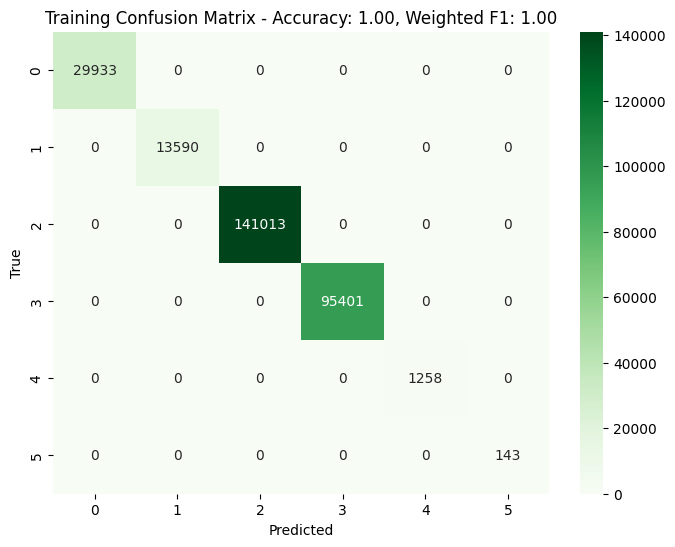

Training Accuracy: 1.0
Training Weighted F1 Score: 1.0


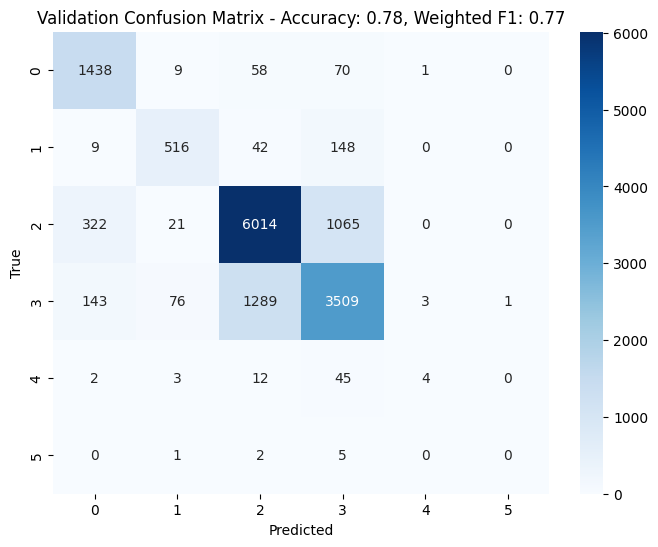

Validation Accuracy: 0.7753241491085899
Validation Weighted F1 Score: 0.7728811169693782
              precision    recall  f1-score   support

           0       0.75      0.91      0.82      1576
           1       0.82      0.72      0.77       715
           2       0.81      0.81      0.81      7422
           3       0.72      0.70      0.71      5021
           4       0.50      0.06      0.11        66
           5       0.00      0.00      0.00         8

    accuracy                           0.78     14808
   macro avg       0.60      0.53      0.54     14808
weighted avg       0.77      0.78      0.77     14808



In [ ]:
# Initialize the XGBClassifier
model = XGBClassifier(
    objective='multi:softmax',  # to get class predictions directly
    num_class=6,                # number of classes
    eval_metric='mlogloss',     # evaluation metric
    use_label_encoder=False,    # disable the old label encoder to avoid warnings
    random_state=42,
    n_estimators=1000,
    max_depth=12
)

# Train the model on the training set
#model.fit(X_train, y_train)
model.fit(X_train, y_train)

# Predict on the training set
y_train_pred = model.predict(X_train)
# Compute confusion matrix, accuracy, and weighted F1 score for training data
cm_train = confusion_matrix(y_train, y_train_pred)
acc_train = accuracy_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred, average='weighted')

# Plot the confusion matrix for training data
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens')
plt.title(f'Training Confusion Matrix - Accuracy: {acc_train:.2f}, Weighted F1: {f1_train:.2f}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Training Accuracy:", acc_train)
print("Training Weighted F1 Score:", f1_train)

# Predict on the validation set
y_val_pred = model.predict(X_val)
# Compute confusion matrix, accuracy, and weighted F1 score for validation data
cm_val = confusion_matrix(y_val, y_val_pred)
acc_val = accuracy_score(y_val, y_val_pred)
f1_val = f1_score(y_val, y_val_pred, average='weighted')

# Plot the confusion matrix for validation data
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.title(f'Validation Confusion Matrix - Accuracy: {acc_val:.2f}, Weighted F1: {f1_val:.2f}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Validation Accuracy:", acc_val)
print("Validation Weighted F1 Score:", f1_val)
print(classification_report(y_val,y_val_pred))


In [65]:
from sklearn.model_selection import cross_validate, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_validate(
    model,
    X_train,
    y_train,
    cv=cv,
    scoring=['accuracy', 'f1_weighted', 'f1_macro'],
    n_jobs=-1
)

for metric in ['accuracy', 'f1_weighted', 'f1_macro']:
    mean = scores[f'test_{metric}'].mean()
    std = scores[f'test_{metric}'].std()
    print(f"{metric}: {mean:.4f} ± {std:.4f}")



/Users/Utilisateur1/TP ML/kaggle-change-detection/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [23:15:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/Utilisateur1/TP ML/kaggle-change-detection/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [23:15:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/Utilisateur1/TP ML/kaggle-change-detection/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning: [23:15:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/Utilisateur1/TP ML/kaggle-change-detection/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarn

accuracy: 0.7772 ± 0.0008
f1_weighted: 0.7744 ± 0.0009
f1_macro: 0.5336 ± 0.0036


In [ ]:

model_final = XGBClassifier(
    objective='multi:softmax',  # to get class predictions directly
    num_class=6,                # number of classes
    eval_metric='mlogloss',     # evaluation metric
    use_label_encoder=False,    # disable the old label encoder to avoid warnings
    random_state=42,
    n_estimators=1000,
    max_depth=12
)

model_final.fit(X_full, y_full)

# Prepare final test set predictions (for rows without missing dates)
test_indexes_final = test_final["index"]
X_test_final = test_final.drop(columns=["index"])

y_test_pred = model_final.predict(X_test_final.values)
predictions_df_final = pd.DataFrame({
    'change_type': y_test_pred,
    'index': test_indexes_final
})


final_submission_df = predictions_df_final

# Sort the final DataFrame by the 'index' column and rename it as "Id"
final_submission_df = final_submission_df.sort_values(by="index")
final_submission_df = final_submission_df.rename(columns={"index": "Id"})

# Save the final predictions to a CSV file
final_submission_df.to_csv("../data/processedfinal_submission_xgb1.csv", index=False)

print("Final submission saved to final_submission.csv")


/Users/Utilisateur1/TP ML/kaggle-change-detection/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning:

[20:55:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.




Final submission saved to final_submission.csv


In [ ]:
model_final = XGBClassifier(
    objective='multi:softmax',  # to get class predictions directly
    num_class=6,                # number of classes
    eval_metric='mlogloss',     # evaluation metric
    use_label_encoder=False,    # disable the old label encoder to avoid warnings
    random_state=42,
    n_estimators=2000,
    max_depth=12
)

model_final.fit(X_full, y_full)

# Prepare final test set predictions (for rows without missing dates)
test_indexes_final = test_final["index"]
X_test_final = test_final.drop(columns=["index"])

y_test_pred = model_final.predict(X_test_final.values)
predictions_df_final = pd.DataFrame({
    'change_type': y_test_pred,
    'index': test_indexes_final
})


final_submission_df = predictions_df_final

# Sort the final DataFrame by the 'index' column and rename it as "Id"
final_submission_df = final_submission_df.sort_values(by="index")
final_submission_df = final_submission_df.rename(columns={"index": "Id"})

# Save the final predictions to a CSV file
final_submission_df.to_csv("../data/processedfinal_submission_xgb1_softprob.csv", index=False)

print("Final submission saved to final_submission.csv")


/Users/Utilisateur1/TP ML/kaggle-change-detection/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning:

[22:35:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.




Final submission saved to final_submission.csv


In [ ]:

# Retrain the model on the entire training set
y_full = train_final['change_type'].values
X_full = train_final.drop(columns=['change_type', 'index'])

model_final = XGBClassifier(
    objective='multi:softmax',  # to get class predictions directly
    num_class=6,                # number of classes
    eval_metric='mlogloss',     # evaluation metric
    use_label_encoder=False,    # disable the old label encoder to avoid warnings
    random_state=42,
    n_estimators=5000,
    max_depth=12
)

model_final.fit(X_full, y_full)

# Prepare final test set predictions (for rows without missing dates)
test_indexes_final = test_final["index"]
X_test_final = test_final.drop(columns=["index"])

y_test_pred = model_final.predict(X_test_final.values)
predictions_df_final = pd.DataFrame({
    'change_type': y_test_pred,
    'index': test_indexes_final
})


final_submission_df = predictions_df_final

# Sort the final DataFrame by the 'index' column and rename it as "Id"
final_submission_df = final_submission_df.sort_values(by="index")
final_submission_df = final_submission_df.rename(columns={"index": "Id"})

# Save the final predictions to a CSV file
final_submission_df.to_csv("../data/processedfinal_submission_xgb1_5000.csv", index=False)

print("Final submission saved to final_submission.csv")


/Users/Utilisateur1/TP ML/kaggle-change-detection/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning:

[23:50:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.




Final submission saved to final_submission.csv


In [ ]:

# Retrain the model on the entire training set
y_full = train_final['change_type'].values
X_full = train_final.drop(columns=['change_type', 'index'])

model_final = XGBClassifier(
    objective='multi:softmax',  # to get class predictions directly
    num_class=6,                # number of classes
    eval_metric='mlogloss',     # evaluation metric
    use_label_encoder=False,    # disable the old label encoder to avoid warnings
    random_state=42,
    n_estimators=1000,
    max_depth=12
)

model_final.fit(X_full, y_full)

# Prepare final test set predictions (for rows without missing dates)
test_indexes_final = test_final["index"]
X_test_final = test_final.drop(columns=["index"])

y_test_pred = model_final.predict(X_test_final.values)
predictions_df_final = pd.DataFrame({
    'change_type': y_test_pred,
    'index': test_indexes_final
})


final_submission_df = predictions_df_final

# Sort the final DataFrame by the 'index' column and rename it as "Id"
final_submission_df = final_submission_df.sort_values(by="index")
final_submission_df = final_submission_df.rename(columns={"index": "Id"})

# Save the final predictions to a CSV file
final_submission_df.to_csv("../data/processedfinal_submission_xgb1_1000.csv", index=False)

print("Final submission saved to final_submission.csv")


/Users/Utilisateur1/TP ML/kaggle-change-detection/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning:

[00:02:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.




Final submission saved to final_submission.csv


In [ ]:

# Retrain the model on the entire training set
y_full = train_final['change_type'].values
X_full = train_final.drop(columns=['change_type', 'index'])

model_final = XGBClassifier(
    objective='multi:softmax',  # to get class predictions directly
    num_class=6,                # number of classes
    eval_metric='mlogloss',     # evaluation metric
    use_label_encoder=False,    # disable the old label encoder to avoid warnings
    random_state=42,
    n_estimators=2000,
    max_depth=12
)

model_final.fit(X_full, y_full)

# Prepare final test set predictions (for rows without missing dates)
test_indexes_final = test_final["index"]
X_test_final = test_final.drop(columns=["index"])

y_test_pred = model_final.predict(X_test_final.values)
predictions_df_final = pd.DataFrame({
    'change_type': y_test_pred,
    'index': test_indexes_final
})


final_submission_df = predictions_df_final

# Sort the final DataFrame by the 'index' column and rename it as "Id"
final_submission_df = final_submission_df.sort_values(by="index")
final_submission_df = final_submission_df.rename(columns={"index": "Id"})

# Save the final predictions to a CSV file
final_submission_df.to_csv("../data/processedfinal_submission_xgb1_2000.csv", index=False)

print("Final submission saved to final_submission.csv")


/Users/Utilisateur1/TP ML/kaggle-change-detection/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning:

[00:05:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.




Final submission saved to final_submission.csv


### Plot the importance of features

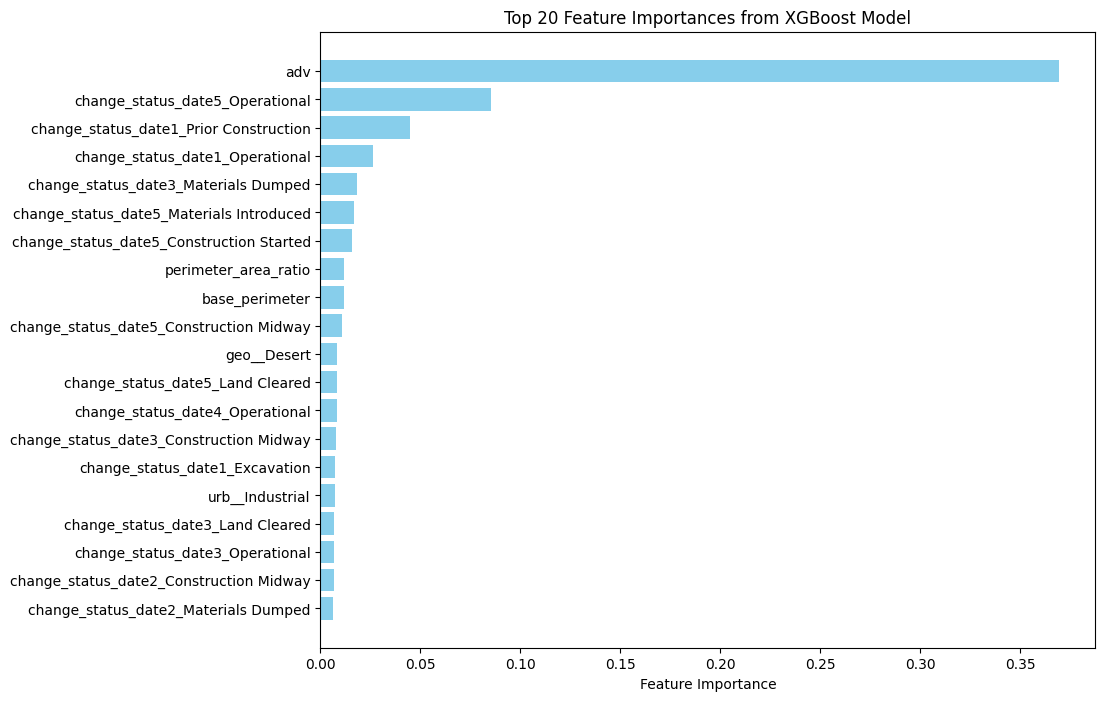

In [107]:
# Before extracting feature importances, ensure the booster has the correct feature names.
# This step aligns the stored feature names with the columns in X_full.
model_final.get_booster().feature_names = list(X_full.columns)

# Extract feature importances from the trained XGBoost model
importances = model_final.feature_importances_
features = X_full.columns

# Create a DataFrame for feature importances
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# Sort and select the top 20 features
feat_imp_top20 = feat_imp_df.sort_values(by='Importance', ascending=False).head(20)

# Plot the top 20 feature importances
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.barh(feat_imp_top20['Feature'][::-1], feat_imp_top20['Importance'][::-1], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances from XGBoost Model')
plt.show()


/Users/Utilisateur1/TP ML/kaggle-change-detection/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning:

[22:18:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.




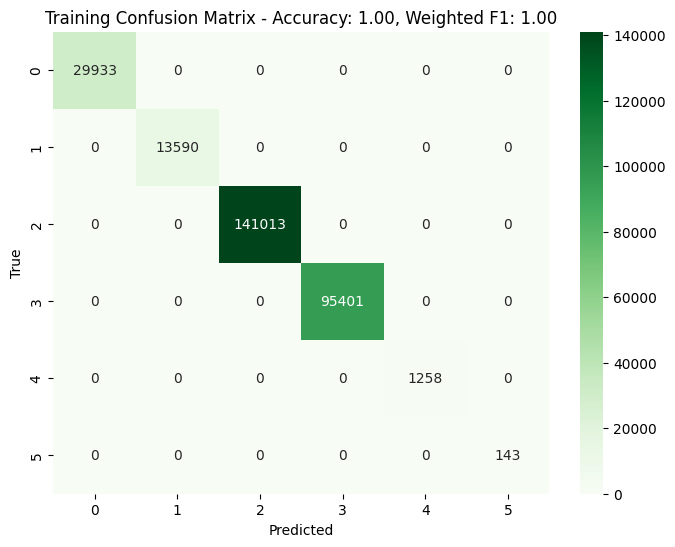

Training Accuracy: 1.0
Training Weighted F1 Score: 1.0


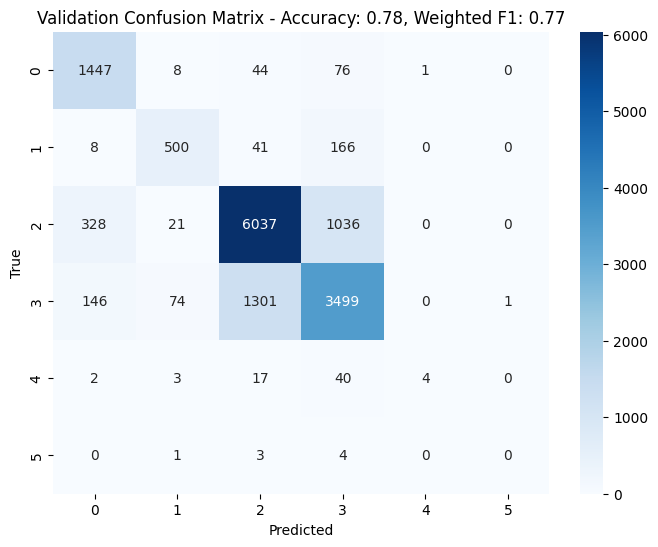

Validation Accuracy: 0.7757293354943274
Validation Weighted F1 Score: 0.7730540588674096


/Users/Utilisateur1/TP ML/kaggle-change-detection/.venv/lib/python3.12/site-packages/xgboost/training.py:200: UserWarning:

[22:20:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.




Final submission saved to final_submission.csv


In [ ]:
# Initialize the XGBClassifier
model = XGBClassifier(
    objective='multi:softmax',  # to get class predictions directly
    num_class=6,                # number of classes
    eval_metric='mlogloss',     # evaluation metric
    use_label_encoder=False,    # disable the old label encoder to avoid warnings
    random_state=42,
    n_estimators=100,
    max_depth=18
)

# Train the model on the training set
model.fit(X_train, y_train)

# Predict on the training set
y_train_pred = model.predict(X_train)
# Compute confusion matrix, accuracy, and weighted F1 score for training data
cm_train = confusion_matrix(y_train, y_train_pred)
acc_train = accuracy_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred, average='weighted')

# Plot the confusion matrix for training data
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens')
plt.title(f'Training Confusion Matrix - Accuracy: {acc_train:.2f}, Weighted F1: {f1_train:.2f}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Training Accuracy:", acc_train)
print("Training Weighted F1 Score:", f1_train)

# Predict on the validation set
y_val_pred = model.predict(X_val)
# Compute confusion matrix, accuracy, and weighted F1 score for validation data
cm_val = confusion_matrix(y_val, y_val_pred)
acc_val = accuracy_score(y_val, y_val_pred)
f1_val = f1_score(y_val, y_val_pred, average='weighted')

# Plot the confusion matrix for validation data
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.title(f'Validation Confusion Matrix - Accuracy: {acc_val:.2f}, Weighted F1: {f1_val:.2f}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Validation Accuracy:", acc_val)
print("Validation Weighted F1 Score:", f1_val)



# Retrain the model on the entire training set
y_full = train_final['change_type'].values
X_full = X

model_final = XGBClassifier(
    objective='multi:softmax',  # to get class predictions directly
    num_class=6,                # number of classes
    eval_metric='mlogloss',     # evaluation metric
    use_label_encoder=False,    # disable the old label encoder to avoid warnings
    random_state=42,
    n_estimators=100,
    max_depth=18
)

model_final.fit(X_full, y_full)

y_test_pred = model_final.predict(X_test_final.values)
predictions_df_final = pd.DataFrame({
    'change_type': y_test_pred,
    'index': test_indexes_final
})

final_submission_df = predictions_df_final

# Sort the final DataFrame by the 'index' column and rename it as "Id"
final_submission_df = final_submission_df.sort_values(by="index")
final_submission_df = final_submission_df.rename(columns={"index": "Id"})

# Save the final predictions to a CSV file
final_submission_df.to_csv("../data/processedfinal_submission_xgb2.csv", index=False)

print("Final submission saved to final_submission.csv")


On Xgboost our best performance was hit on `n_estimators=2000` and `max_depth=12`

### Try with random forest models

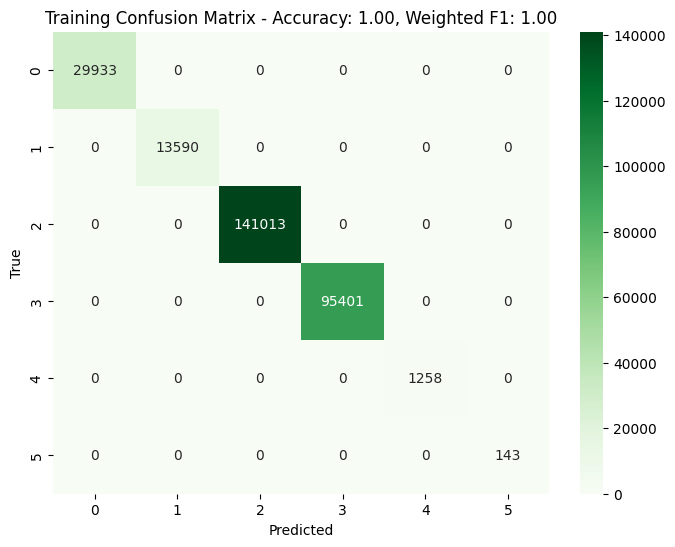

Training Accuracy (RF): 1.0
Training Weighted F1 Score (RF): 1.0


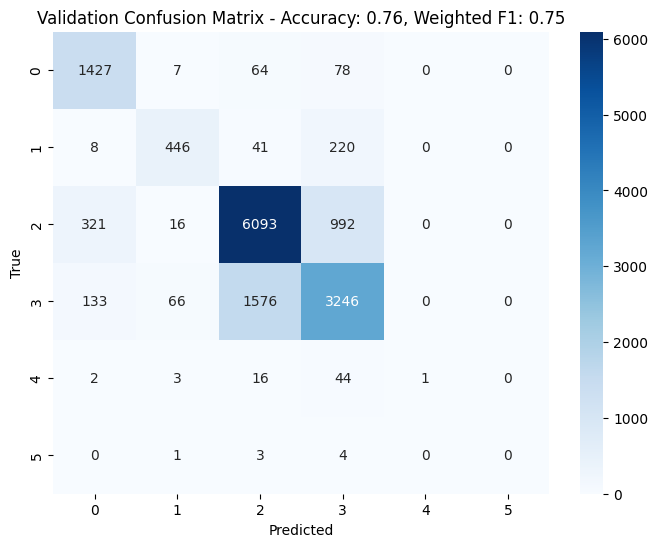

Validation Accuracy (RF): 0.7572258238789843
Validation Weighted F1 Score (RF): 0.7527030809560274


/Users/Utilisateur1/TP ML/kaggle-change-detection/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



Final submission (Random Forest) saved to final_submission.csv


In [162]:
# Initialize the RandomForestClassifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

# Train the model on the training set
rf_model.fit(X_train, y_train)

# Predict on the training set
y_train_pred_rf = rf_model.predict(X_train)
# Compute confusion matrix, accuracy, and weighted F1 score for training data
cm_train_rf = confusion_matrix(y_train, y_train_pred_rf)
acc_train_rf = accuracy_score(y_train, y_train_pred_rf)
f1_train_rf = f1_score(y_train, y_train_pred_rf, average='weighted')

# Plot the confusion matrix for training data
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train_rf, annot=True, fmt='d', cmap='Greens')
plt.title(f'Training Confusion Matrix - Accuracy: {acc_train_rf:.2f}, Weighted F1: {f1_train_rf:.2f}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Training Accuracy (RF):", acc_train_rf)
print("Training Weighted F1 Score (RF):", f1_train_rf)

# Predict on the validation set
y_val_pred_rf = rf_model.predict(X_val)
# Compute confusion matrix, accuracy, and weighted F1 score for validation data
cm_val_rf = confusion_matrix(y_val, y_val_pred_rf)
acc_val_rf = accuracy_score(y_val, y_val_pred_rf)
f1_val_rf = f1_score(y_val, y_val_pred_rf, average='weighted')

# Plot the confusion matrix for validation data
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val_rf, annot=True, fmt='d', cmap='Blues')
plt.title(f'Validation Confusion Matrix - Accuracy: {acc_val_rf:.2f}, Weighted F1: {f1_val_rf:.2f}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Validation Accuracy (RF):", acc_val_rf)
print("Validation Weighted F1 Score (RF):", f1_val_rf)

# Retrain the Random Forest model on the entire training set
y_full = train_final['change_type'].values
X_full = train_final.drop(columns=['change_type', 'index'])

rf_model_final = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)
rf_model_final.fit(X_full, y_full)

# Prepare final test set predictions (for rows without missing dates)
test_indexes_final = test_final["index"]
X_test_final = test_final.drop(columns=["index"])

y_test_pred_rf = rf_model_final.predict(X_test_final.values)
predictions_df_final_rf = pd.DataFrame({
    'change_type': y_test_pred_rf,
    'index': test_indexes_final
})

# Merge predictions with the rows that had missing dates (which were already assigned the majority class)
final_submission_df_rf = predictions_df_final_rf

# Sort the final DataFrame by the 'index' column and rename it as "Id"
final_submission_df_rf = final_submission_df_rf.sort_values(by="index")
final_submission_df_rf = final_submission_df_rf.rename(columns={"index": "Id"})

# Save the final predictions to a CSV file
final_submission_df_rf.to_csv("../data/processed/final_submission_rf1.csv", index=False)

print("Final submission (Random Forest) saved to final_submission.csv")


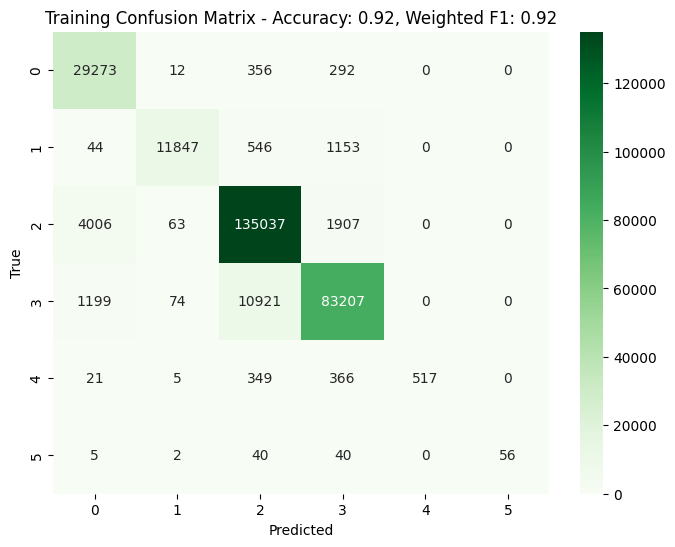

Training Accuracy (RF): 0.9239313565888717
Training Weighted F1 Score (RF): 0.9232474638357484


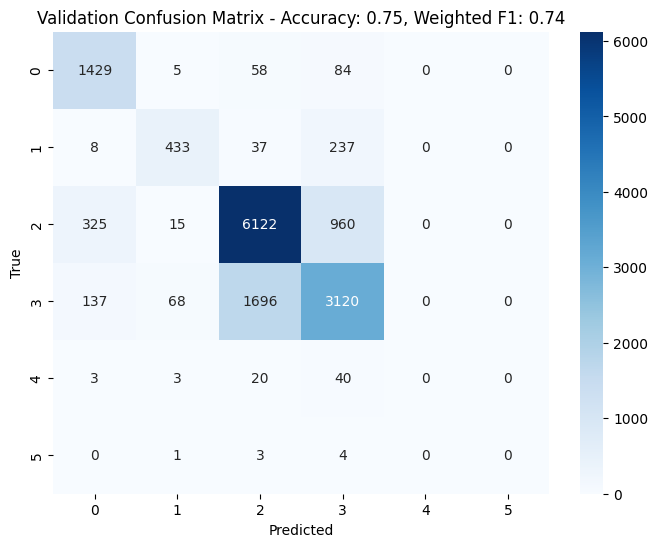

Validation Accuracy (RF): 0.7498649378714208
Validation Weighted F1 Score (RF): 0.744284387653147


/Users/Utilisateur1/TP ML/kaggle-change-detection/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



Final submission (Random Forest) saved to final_submission.csv


In [ ]:
# Initialize the RandomForestClassifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=20
)

# Train the model on the training set
rf_model.fit(X_train, y_train)

# Predict on the training set
y_train_pred_rf = rf_model.predict(X_train)
# Compute confusion matrix, accuracy, and weighted F1 score for training data
cm_train_rf = confusion_matrix(y_train, y_train_pred_rf)
acc_train_rf = accuracy_score(y_train, y_train_pred_rf)
f1_train_rf = f1_score(y_train, y_train_pred_rf, average='weighted')

# Plot the confusion matrix for training data
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train_rf, annot=True, fmt='d', cmap='Greens')
plt.title(f'Training Confusion Matrix - Accuracy: {acc_train_rf:.2f}, Weighted F1: {f1_train_rf:.2f}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Training Accuracy (RF):", acc_train_rf)
print("Training Weighted F1 Score (RF):", f1_train_rf)

# Predict on the validation set
y_val_pred_rf = rf_model.predict(X_val)
# Compute confusion matrix, accuracy, and weighted F1 score for validation data
cm_val_rf = confusion_matrix(y_val, y_val_pred_rf)
acc_val_rf = accuracy_score(y_val, y_val_pred_rf)
f1_val_rf = f1_score(y_val, y_val_pred_rf, average='weighted')

# Plot the confusion matrix for validation data
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val_rf, annot=True, fmt='d', cmap='Blues')
plt.title(f'Validation Confusion Matrix - Accuracy: {acc_val_rf:.2f}, Weighted F1: {f1_val_rf:.2f}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Validation Accuracy (RF):", acc_val_rf)
print("Validation Weighted F1 Score (RF):", f1_val_rf)

# Retrain the Random Forest model on the entire training set
y_full = train_final['change_type'].values
X_full = train_final.drop(columns=['change_type', 'index'])

rf_model_final = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=20
)
rf_model_final.fit(X_full, y_full)

# Prepare final test set predictions (for rows without missing dates)
test_indexes_final = test_final["index"]
X_test_final = test_final.drop(columns=["index"])

y_test_pred_rf = rf_model_final.predict(X_test_final.values)
predictions_df_final_rf = pd.DataFrame({
    'change_type': y_test_pred_rf,
    'index': test_indexes_final
})

# Merge predictions with the rows that had missing dates (which were already assigned the majority class)
final_submission_df_rf = predictions_df_final_rf

# Sort the final DataFrame by the 'index' column and rename it as "Id"
final_submission_df_rf = final_submission_df_rf.sort_values(by="index")
final_submission_df_rf = final_submission_df_rf.rename(columns={"index": "Id"})

# Save the final predictions to a CSV file
final_submission_df_rf.to_csv("../data/processedfinal_submission_rf2.csv", index=False)

print("Final submission (Random Forest) saved to final_submission.csv")


## Conclusion

Given that some classes have very few samples, the test score may not be entirely representative, especially since only 5% of the data was used in a stratified split—a choice driven by the enormous class imbalance. This imbalance contributes to the observed gap between training and test scores. On Kaggle's leaderboard, we achieved approximately 96%, but we expect this score to drop by roughly 8% when evaluated on the final test set due to a slight loss in generalization.
